In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cd /content/drive/My Drive/Colab Notebooks/Research/GazeSemgIntegration/more_features

/content/drive/My Drive/Colab Notebooks/Research/GazeSemgIntegration/more_features


In [80]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lightgbm as ltb
from copy import deepcopy
import warnings
import math


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings('ignore')

# Find training data (over lapping window=200ms, step=50ms)

In [11]:
trainx = pd.read_csv('featured_data/step50ms/combined_trainx.csv')
trainy = pd.read_csv('featured_data/step50ms/combined_trainy.csv')


## Plot training data

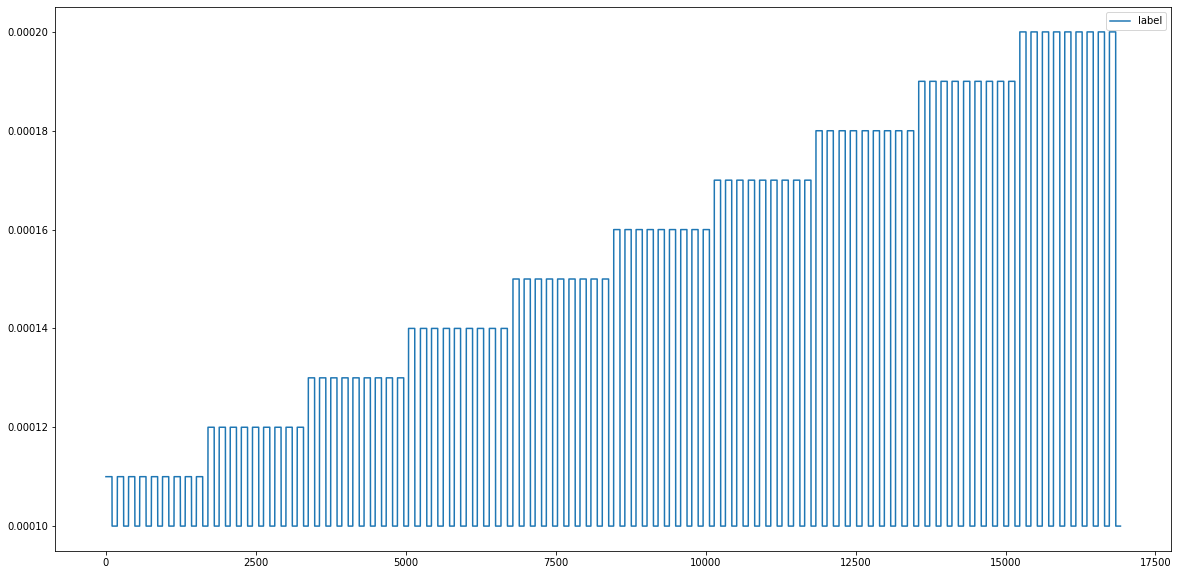

In [34]:
# index = np.array(trainx.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(trainy*0.00001+0.0001)
# for i in tqdm(range(0,12)):
#     ax.plot(index, trainx[i])
    
line1.set_label('label')
ax.legend()
plt.show();

# Find raw testing data

In [19]:
subject_number = 1

static_end = []

for i in tqdm(range(10,10+subject_number)):
    current_dynamic = pd.read_csv('data_all_intact/S0' + str(i) + '_dynamic.csv', header=None)

    for j in range(len(current_dynamic)-1, -1, -1):
        if current_dynamic.iloc[j,0] == 0:
            static_end.append(j)
            break
for i in tqdm(range(10,10+subject_number)):
    # read csv files
    current_emg = pd.read_csv('data_all_intact/S0' + str(i) + '_emg.csv', header=None)
    current_grasp = pd.read_csv('data_all_intact/S0' + str(i) + '_grasp.csv', header=None)
    current_grasprepetition = pd.read_csv('data_all_intact/S0' + str(i) + '_grasprepetition.csv', header=None)

    current_static_emg = current_emg.iloc[0:static_end[i-10]]
    current_static_grasp = current_grasp.iloc[0:static_end[i-10]]
    current_static_grasprepetition = current_grasprepetition.iloc[0:static_end[i-10]]

    # find raw train/test data
    test_index = []
    for j in tqdm(range(len(current_static_grasprepetition))):
        if current_static_grasprepetition.iloc[j,0] in [10,11,12]:
            test_index.append(j)
    testx_raw = current_static_emg.iloc[test_index].reset_index(drop=True)
    testy_raw = current_static_grasp.iloc[test_index].reset_index(drop=True)

## Plot the raw testing data

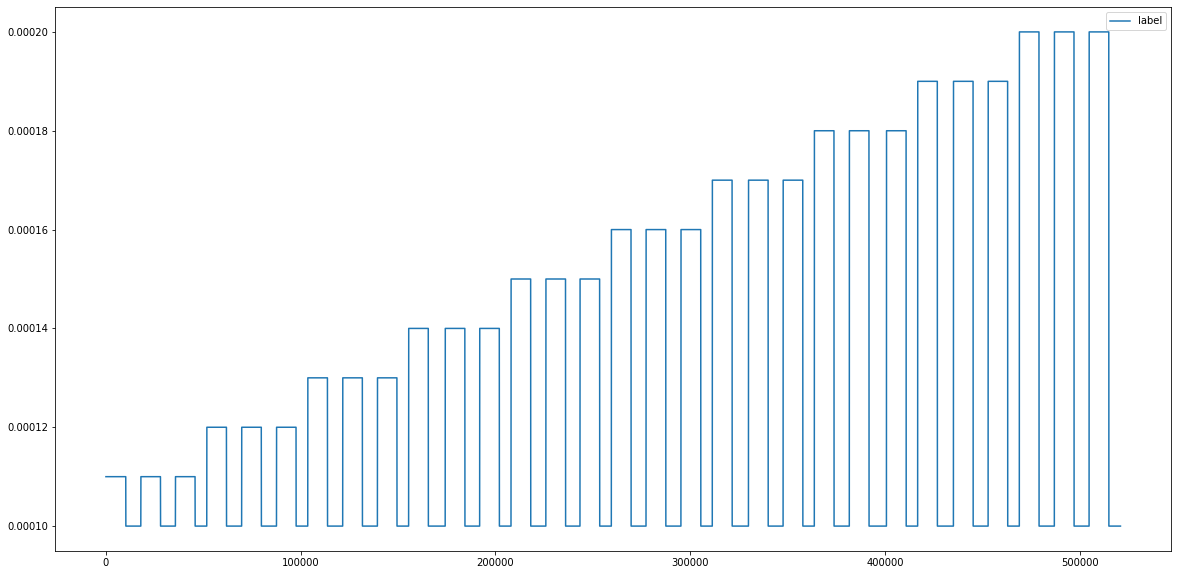

In [21]:
# index = np.array(testy.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy_raw*0.00001+0.0001)
# for i in tqdm(range(0,12)):
#     ax.plot(index, trainx[i])
    
line1.set_label('label')
ax.legend()
plt.show();

# Test half-half transition zone

## Preparation

### Find the transition zone test data index

In [32]:
# find the 59 turning point
counter = 0
last = 1
turning_point=[]
for i in tqdm(range(0, len(testy_raw))):
    current = testy_raw.iloc[i,0]
    if last == current:
        last = current
    else:
        last = current
        counter += 1
        turning_point.append(i)
    if counter == 59:
        break

### Define features function

In [81]:
def rms(self):
    current =0
    square =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        square += current ** 2
    mean = square/len(self)
    root = math.sqrt(mean)
    return root

def iemg(self):
    current =0
    absolute =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        absolute += np.abs(current)
    return absolute

def mav(self):
    current =0
    absolute =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        absolute += np.abs(current)
    return absolute/len(self)

def wl(self):
    current =0
    diff =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        diff += np.abs(current - self.iloc[i-1])
    return diff

def ssi(self):
    current =0
    square = 0
    for i in range(0, len(self)):
        current = self.iloc[i]
        square += current ** 2
    return square

def aac(self):
    current =0
    diff =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        diff += np.abs(current - self.iloc[i-1])
    return diff/len(self)

def dasdv(self):
    current =0
    square =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        square += (current - self.iloc[i-1])**2
    return square/(len(self)-1)

### Define results array

In [130]:
acc_arr = []
tran_win_size_arr = []
overlap_win_size_arr = []
step_arr = []

### Train the model

In [131]:
# train model
lightGBM_model = ltb.LGBMClassifier()
lightGBM_model.fit(trainx,trainy)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Transition zone window size = 100 ms

In [147]:
# find transition zone testing data
window_size = 166

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [148]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr.append(accuracy)
tran_win_size_arr.append(window_size)
overlap_win_size_arr.append(overlap_window)
step_arr.append(step)

## Transition zone window size = 200 ms

In [149]:
# find transition zone testing data
window_size = 385

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [150]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr.append(accuracy)
tran_win_size_arr.append(window_size)
overlap_win_size_arr.append(overlap_window)
step_arr.append(step)

## Transition zone window size = 300 ms

In [151]:
# find transition zone testing data
window_size = 500

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [152]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr.append(accuracy)
tran_win_size_arr.append(window_size)
overlap_win_size_arr.append(overlap_window)
step_arr.append(step)

## Transition zone window size = 400 ms

In [153]:
# find transition zone testing data
window_size = 665

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [154]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr.append(accuracy)
tran_win_size_arr.append(window_size)
overlap_win_size_arr.append(overlap_window)
step_arr.append(step)

## Transition zone window size = 500 ms

In [155]:
# find transition zone testing data
window_size = 832

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [156]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr.append(accuracy)
tran_win_size_arr.append(window_size)
overlap_win_size_arr.append(overlap_window)
step_arr.append(step)

## Results

In [157]:
acc_arr
tran_win_size_arr
overlap_win_size_arr
step_arr

[0.43434343434343436,
 0.4482758620689655,
 0.47368421052631576,
 0.47901234567901235,
 0.32441471571906355,
 0.43434343434343436,
 0.4482758620689655,
 0.47368421052631576,
 0.47901234567901235,
 0.5137795275590551]

[166, 385, 500, 665, 500, 166, 385, 500, 665, 832]

[385, 385, 385, 385, 832, 385, 385, 385, 385, 385]

[96, 96, 96, 96, 96, 96, 96, 96, 96, 96]

# Test left transition zone

## Preparation

### Find the transition zone test data index

In [159]:
# find the 59 turning point
counter = 0
last = 1
turning_point=[]
for i in tqdm(range(0, len(testy_raw))):
    current = testy_raw.iloc[i,0]
    if last == current:
        last = current
    else:
        last = current
        counter += 1
        turning_point.append(i)
    if counter == 59:
        break

### Define features function

In [160]:
def rms(self):
    current =0
    square =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        square += current ** 2
    mean = square/len(self)
    root = math.sqrt(mean)
    return root

def iemg(self):
    current =0
    absolute =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        absolute += np.abs(current)
    return absolute

def mav(self):
    current =0
    absolute =0
    for i in range(0, len(self)):
        current = self.iloc[i]
        absolute += np.abs(current)
    return absolute/len(self)

def wl(self):
    current =0
    diff =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        diff += np.abs(current - self.iloc[i-1])
    return diff

def ssi(self):
    current =0
    square = 0
    for i in range(0, len(self)):
        current = self.iloc[i]
        square += current ** 2
    return square

def aac(self):
    current =0
    diff =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        diff += np.abs(current - self.iloc[i-1])
    return diff/len(self)

def dasdv(self):
    current =0
    square =0
    for i in range(1, len(self)):
        current = self.iloc[i]
        square += (current - self.iloc[i-1])**2
    return square/(len(self)-1)

### Define results array

In [161]:
acc_arr_left = []
tran_win_size_arr_left = []
overlap_win_size_arr_left = []
step_arr_left = []

### Train the model

In [162]:
# train model
lightGBM_model = ltb.LGBMClassifier()
lightGBM_model.fit(trainx,trainy)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Transition zone window size = 100 ms

In [163]:
# find transition zone testing data
window_size = 166

testx_tran = testx_raw.iloc[turning_point[0]-window_size:turning_point[0], :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size:turning_point[0], :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size:turning_point[i], :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size:turning_point[i], :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [164]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr_left.append(accuracy)
tran_win_size_arr_left.append(window_size)
overlap_win_size_arr_left.append(overlap_window)
step_arr_left.append(step)

## Transition zone window size = 200 ms

In [166]:
# find transition zone testing data
window_size = 385

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [167]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr_left.append(accuracy)
tran_win_size_arr_left.append(window_size)
overlap_win_size_arr_left.append(overlap_window)
step_arr_left.append(step)

## Transition zone window size = 300 ms

In [168]:
# find transition zone testing data
window_size = 500

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [169]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr_left.append(accuracy)
tran_win_size_arr_left.append(window_size)
overlap_win_size_arr_left.append(overlap_window)
step_arr_left.append(step)

## Transition zone window size = 400 ms

In [170]:
# find transition zone testing data
window_size = 665

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [171]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr_left.append(accuracy)
tran_win_size_arr_left.append(window_size)
overlap_win_size_arr_left.append(overlap_window)
step_arr_left.append(step)

## Transition zone window size = 500 ms

In [172]:
# find transition zone testing data
window_size = 832

testx_tran = testx_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
testy_tran = testy_raw.iloc[turning_point[0]-window_size//2:turning_point[0]+window_size//2, :]
for i in range(1, len(turning_point)):
    testx_tran = testx_tran.append(testx_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])
    testy_tran = testy_tran.append(testy_raw.iloc[turning_point[i]-window_size//2:turning_point[i]+window_size//2, :])

testx_tran = testx_tran.reset_index(drop=True)
testy_tran = testy_tran.reset_index(drop=True)

### Apply 8 overlapping windows to transition test data. overlapping window = 200ms, step = 50ms

In [ ]:
# parameters
overlap_window = 385 # 200ms
step = 96 # 50ms

# apply std and generate initial test data
testx = []
testy = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(testx_tran.iloc[a-overlap_window:a+1,b].std())
    testx.append(current_row)
    testy.append(testy_tran.iloc[a, 0])

testx = pd.DataFrame(testx)
testy = pd.DataFrame(testy)

# apply rms and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(rms(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply iemg and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(iemg(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply mav and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(mav(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply wl and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(wl(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply ssi and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(ssi(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply aac and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(aac(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# apply dasdv and generate initial test data
testx_current = []
testy_current = []

for a in tqdm(range(overlap_window,len(testx_tran),step)):
    current_row = []
    for b in range(0,12):
        current_row.append(dasdv(testx_tran.iloc[a-overlap_window:a+1,b]))
    testx_current.append(current_row)
    testy_current.append(testy_tran.iloc[a, 0])

testx_current = pd.DataFrame(testx_current)
testy_current = pd.DataFrame(testy_current)

testx = pd.concat([testx,testx_current],axis=1)

# test model
expected1 = testy.values.flatten()
predicted1 = lightGBM_model.predict(testx)
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy = counter/len(expected1)

acc_arr_left.append(accuracy)
tran_win_size_arr_left.append(window_size)
overlap_win_size_arr_left.append(overlap_window)
step_arr_left.append(step)

## Results

In [ ]:
acc_arr_left
tran_win_size_arr_left
overlap_win_size_arr_left
step_arr_left